In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
from scipy.interpolate import splrep, splev
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

## Trend filtering after spatial denoising

### code of Zheng
https://github.com/zhh210/pdastf

In [2]:
from trendFiltering.trendfilter import TF, TFsafe, TFsafeG

### code of L1-TF
http://www.cvxpy.org/en/1.0/examples/applications/l1_trend_filter.html

* number of iteration and compuation time should be in `prob.solver_stats.__dict__`, but it is not readable for `CVXOPT solver`

In [3]:
import cvxpy as cvx
import cvxopt as cvxopt


def L1TF_D2(y, vlambda=50):
    from time import time
    y = y[:,np.newaxis]
    n = y.size
    # Form second difference matrix.
    e = np.mat(np.ones((1, n)))
    D = sp.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
    # D_coo = D.tocoo()
    # D = cvxopt.spmatrix(D_coo.data, D_coo.row.tolist(), D_coo.col.tolist())
    
    # Solve l1 trend filtering problem.
    x = cvx.Variable(rows=n)
    obj = cvx.Minimize(0.5 * cvx.sum_squares(y - x) + vlambda * cvx.norm(D*x, 1) )
    prob = cvx.Problem(obj)
    # ECOS and SCS solvers fail to converge before the iteration limit. Use CVXOPT instead.
    
    # computation time
    start = time()
    prob.solve(solver=cvx.CVXOPT,verbose=False)
    dur = time() - start
    
    # print('Solver status: %s'%(prob.status))
    # Check for error.
    if prob.status != cvx.OPTIMAL:
        raise Exception("Solver did not converge!")
    return x.value, dur

def lambda_max_D2(y):
    y = y[:,np.newaxis]
    n = y.size
    e = np.mat(np.ones((1, n)))
    D = sp.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n).todense()
    return np.linalg.norm(np.dot(np.linalg.pinv(D.T), y), ord=np.inf)

### Simulated data

In [4]:
xp = np.array([1, 100, 150, 260, 300, 350, 400], dtype='float64')
yp = np.array([3, 10, -2, -5, 9, 2, 6], dtype='float64')
x = np.linspace(1, 400, num=400)
spl = splrep(xp, yp)
y = splev(x, spl)
y = y + np.random.normal(size = y.shape)*5

#### Zheng Han's code

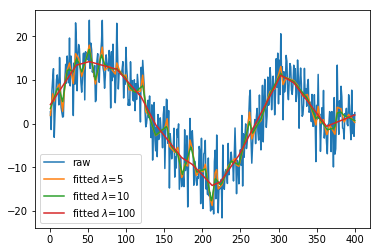

In [5]:
plt.plot(x, y, label='raw')
weights = np.ones(max(y.shape))
for lam in [5, 10, 100]:
    prob = TF(y[:,np.newaxis],lam,order=2,mode = -1)
    prob.silence = True
    prob.pdas()
    plt.plot(x, prob.x, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show()    

#### code of L1-TF

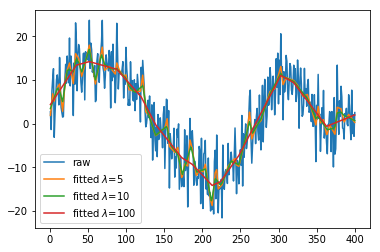

In [6]:
plt.plot(x, y, label='raw')
weights = np.ones(max(y.shape))
for lam in [5, 10, 100]:
    prob_x, dur = L1TF_D2(y, vlambda=lam)
    plt.plot(x, prob_x, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show() 

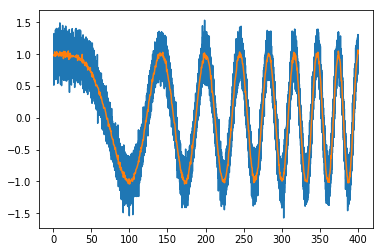

In [7]:
numData = 40000.
x = np.linspace(1, 400, num=int(numData))
y = np.cos(x**2/10000*np.pi)
y = y + np.random.normal(size = y.shape)*0.15
prob = TF(y[:,np.newaxis],5,order=2,mode = -1)
prob.silence = True
prob.pdas()
plt.plot(x, y)
plt.plot(x, prob.x)
plt.show()

#### Performance of Zheng's code

In [14]:
timeList = []
iterList = []
sizeData = [400, 800, 1200, 1600, 2000, 4000, 8000, 20000, 40000]
for nData in sizeData:
    x = np.linspace(1, 400, num=nData)
    y = np.cos(x**2/10000*np.pi)
    y = y + np.random.normal(size = y.shape)*0.15
    prob = TF(y[:,np.newaxis],5,order=2,mode = -1)
    prob.silence = True
    prob.pdas()
    timeList.append(prob.info['time'])
    iterList.append(prob.info['iter'])

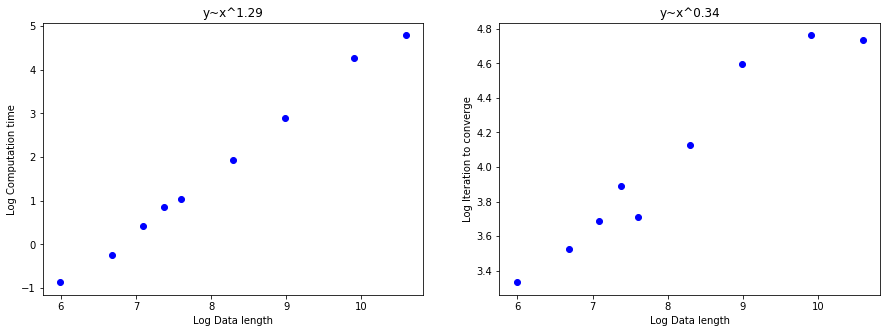

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.log(sizeData), np.log(timeList), 'ob')
p = np.polyfit(np.log(sizeData), np.log(timeList), 1)
ax[0].set_ylabel('Log Computation time')
ax[0].set_xlabel('Log Data length')
ax[0].set_title('y~x^%0.2f'%(p[0]))
ax[1].plot(np.log(sizeData), np.log(iterList), 'ob')
p = np.polyfit(np.log(sizeData), np.log(iterList), 1)
ax[1].set_ylabel('Log Iteration to converge')
ax[1].set_xlabel('Log Data length')
ax[1].set_title('y~x^%0.2f'%(p[0]))
plt.show()

#### Performance of L1-TF code

In [18]:
timeList = []
sizeData = [400, 800, 1200, 1600, 2000, 4000, 8000] # got memory leak error as sizeData >= 20000
for nData in sizeData:
    x = np.linspace(1, 400, num=nData)
    y = np.cos(x**2/10000*np.pi)
    y = y + np.random.normal(size = y.shape)*0.15
    _, dur = L1TF_D2(y, vlambda=5)
    timeList.append(dur)

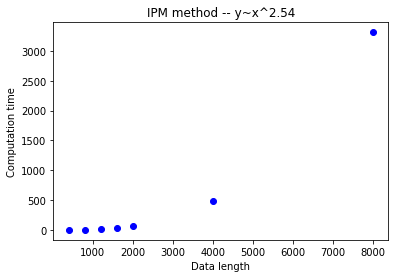

In [25]:
fig, ax = plt.subplots()
ax.plot(sizeData, timeList, 'ob')
p = np.polyfit(np.log(sizeData), np.log(timeList), 1)
ax.set_ylabel('Computation time')
ax.set_xlabel('Data length')
ax.set_title('IPM method -- y~x^%0.2f'%(p[0]))
# ax[1].plot(np.log(sizeData), np.log(iterList), 'ob')
# p = np.polyfit(np.log(sizeData), np.log(iterList), 1)
# ax[1].set_ylabel('Log Iteration to converge')
# ax[1].set_xlabel('Log Data length')
# ax[1].set_title('y~x^%0.2f'%(p[0]))
plt.show()

### Load TK's data

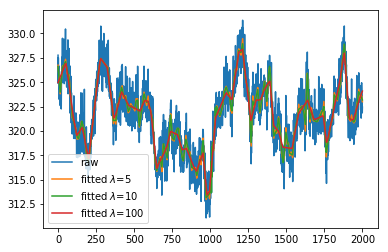

In [26]:
cropSDN = sio.loadmat('cropSDN.mat')['cropSDN'][0]
x = np.arange(cropSDN.shape[0])
plt.plot(x, cropSDN, label='raw')
weights = np.ones(max(y.shape))
for lam in [5, 10, 100]:
    prob = TF(cropSDN[:,np.newaxis],lam,order=2,mode = -1)
    prob.silence = True
    prob.pdas()
    plt.plot(x, prob.x, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show()